In [3]:
#importing packages

from SCHyA import SCHyA as hy
# import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

2023-07-03 21:29:00.436349: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-03 21:29:00.437672: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-03 21:29:00.460741: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-03 21:29:00.461243: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 21:29:00.855363: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [4]:
#input path to your .csv from ICY
csv_path = '/home/noah/Documents/NoahT2022/CodeRepos/Utopia/testOutputs/dataframe.csv'
csv_path = '/home/noah/Documents/NoahT2022/Data/SingleCell_Tracking/ALI_comp/redTracks.csv'

#path to numpy tracks saved from tracking code
numpy_path = '/home/noah/Documents/NoahT2022/CodeRepos/Utopia/testOutputs/tracks.npy'

#input path to .avi of GCaMP Video
vid_path = '/home/noah/Desktop/cellsegtest/segTestNew/shortStack_adjusted'

#input path to .avi of tdTomato Video
red_vid_path ='/home/noah/Desktop/cellsegtest/segTestNew/shortStack_adjusted'

In [5]:
positions, vid, red_vid = hy.Read_Data_TIFseq_byo(numpy_path, vid_path, red_vid_path)

In [6]:
positions_reshaped = np.transpose(positions, (1,0,2)) #https://stackoverflow.com/questions/68700008/difference-between-just-reshaping-and-reshaping-and-getting-transpose

In [11]:
def npy_remove_incomplete_tracks(tracks_reshaped):

    complete_tracks = []
    incomplete_tracks = []
    indexes = []

    for i, track in enumerate(tracks_reshaped):
        hasNaN = np.isnan(track).any()
        if hasNaN:
            incomplete_tracks.append(track)
            indexes.append(i)
        else:
            complete_tracks.append(track)
    
    return np.asarray(complete_tracks), [incomplete_tracks, indexes]

posit_corrected, removed_tracks = npy_remove_incomplete_tracks(positions_reshaped)

In [12]:
#Extract the fluorescence intensity in the GCaMP channel throughout the video for each neuron

#size of ROI
# dim = 9
dim=9
# subROI_Circle_size = 4
subROI_Circle_size = 3
LookBack = 1 #resistance of tracking to movement i.e. how quickly a tracked neuron can move before position resets

#Extract large ROI and remove points too close to edge
intensities_raw, posit_corrected_raw = hy.Extract_Fluorescence(posit_corrected, vid, dimention = dim)

#extract signal from subROI around neuron
# intensities1, posit_corrected1, neuron_pts = hy.SingleCellIntensities(vid, posit_corrected_raw, dim, subROI_Circle_size, LookBack)

In [43]:
#TODO using the sequence loader gives frames in wrong format for cv2 rgb2gray function - need to run conversion either in data loader or in single cell function (or both)

In [13]:
intensities_red, posit_corrected1 = hy.Extract_Fluorescence(posit_corrected_raw, red_vid, dim)

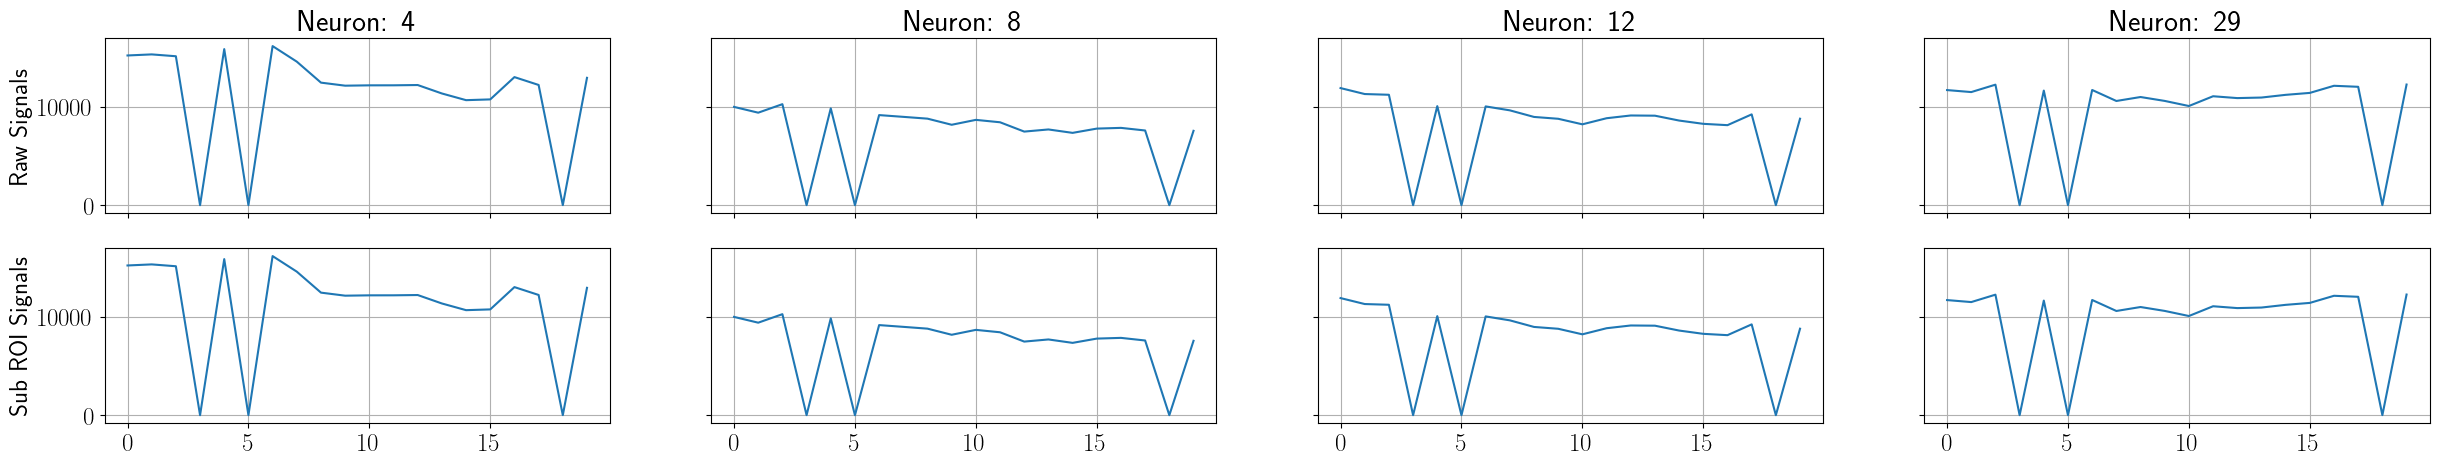

In [17]:
#Figure1 subplots 
import matplotlib as mpl
keyCells = range(30)
keyCells = [4,8,12,29]

mpl.rcParams.update({'font.size': 18, "text.usetex": True})
fig, axs = plt.subplots(2, len(keyCells), sharex =True, sharey=True, figsize=(30, 5))


# axs.xlabel("x", fontsize=80)
# axs.ylabel("y", fontsize=80)
# axs.xlim(-3, 3)
# axs.ylim(-1.05, 1.05)

styles = ["o", "^", "s", "X", "*"]
default_color_iter = plt.rcParams["axes.prop_cycle"]()




axs[0,0].set_ylabel('Raw Signals')
axs[1,0].set_ylabel('Sub ROI Signals')

for i, neuron in enumerate(keyCells):
    axs[0,i].set_title('Neuron: ' + str(neuron))

    axs[0,i].plot(intensities_raw[neuron])
    axs[0,i].grid()
    axs[1,i].grid()
    axs[1,i].plot(intensities_raw[neuron]) #these might not line up if there is an issue with points being removed!
    
# fig.text(0.5, -0.05, 'Frames', ha='center', fontsize = 30)
# fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')
plt.savefig("/home/noah/Documents/NoahT2022/utopiaFigures/rawvsROI_signals.svg", format = "svg")
plt.show()

In [ ]:
np.isnan(tracks[:,2]).any()

In [ ]:
def hasNaNs(index):
    i = index
    hasNaN = np.isnan(tracks[:,i]).any()
    return hasNaN

def hasNaNs2(column):
    # i = index
    hasNaN = np.isnan(column).any()
    return hasNaN

# any(np.isnan(tracks[:,2]))

In [ ]:
complete_tracks = []
incomplete_tracks = []
indexes = []
for i in range(tracks.shape[1]):
    hasNaN = np.isnan(tracks[:,i]).any()
    if hasNaN:
        incomplete_tracks.append(tracks[:,i])
        indexes.append(i)
    else:
        complete_tracks.append(tracks[:,i])

In [ ]:
print(indexes)
print('number Removed: ', len(indexes))
print('num kept: ', len(complete_tracks))

In [ ]:
completetracks = [hasNaNs2(track[:,i]) for  ]

In [ ]:
print(tracks.shape)

df = pd.DataFrame(data = tracks.tolist())

In [ ]:
df

In [ ]:
df.apply(hasNaNs2, axis=0)

In [ ]:
df.columns[df.isna().any()].tolist()

In [ ]:
num_frames = tracks.shape[1]

In [ ]:
#reshape tracks
posit_corrected = hy.remove_incomplete_tracks(tracks, num_frames)

In [ ]:
len(posit_corrected)

In [ ]:
positions = (pd.read_csv(csv_path,usecols=['TrackID','t','x','y']))

trackIDs = positions.TrackID.unique()
grouped = positions.groupby(['TrackID'])

posit = np.asanyarray([grouped.get_group(neuron).loc[:, ['x', 'y']].values for neuron in trackIDs], dtype='object')

In [ ]:
posit[0]

In [ ]:
positions = pd.read_csv(csv_path, dtype = 'object', converters={'0': pd.eval})
# positions.drop(positions.columns[0], axis=1, inplace=True)

positions

In [ ]:
from ast import literal_eval


In [ ]:
posit_corrected = complete_tracks

In [ ]:
len(posit_corrected)

In [ ]:
_, red, green = hy.Read_Data_TIFseq(vid_path, red_vid_path, csv_path)